In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img = cv2.imread("data/daisy/5547758_eea9edfd54_n.jpg")

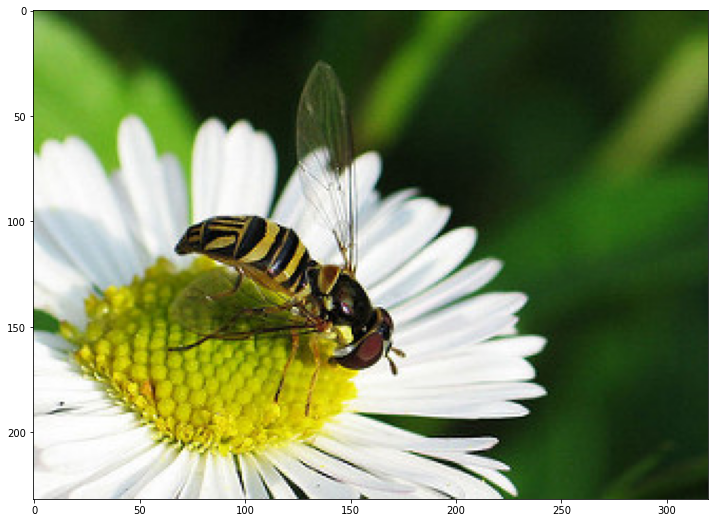

In [3]:
plt.rcParams["figure.figsize"] = (16, 9)

plt.imshow(img[:,:,::-1])
plt.show()

In [4]:
imgf32 = (img / 255).astype(np.float32)
imgf32.shape, imgf32.dtype

((232, 320, 3), dtype('float32'))

In [5]:
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
mag.shape, angle.shape

((232, 320, 3), (232, 320, 3))

In [6]:
# take max of mag along BGR channels
max_mag_mask = np.argmax(mag, axis=2, keepdims=True)

In [7]:
# apply the mask to both mag and angle matrix
mag = np.take_along_axis(mag, max_mag_mask, axis=2).squeeze()
angle = np.take_along_axis(angle, max_mag_mask, axis=2).squeeze()
mag.shape, angle.shape

((232, 320), (232, 320))

In [8]:
# map the function to the angle vector to get "unsigned" gradients
np.vectorize(lambda x: x - 180 if x > 180 else x)(angle)
angle

array([[  0.      , 180.      , 180.      , ...,   0.      ,   0.      ,
          0.      ],
       [ 90.      , 110.77664 , 108.438675, ...,  75.96222 ,  14.037778,
         90.      ],
       [ 90.      , 120.96007 , 114.23156 , ..., 198.43867 ,  63.432896,
         90.      ],
       ...,
       [270.      ,   0.      , 315.00955 , ..., 104.03778 , 120.96007 ,
         90.      ],
       [ 90.      ,  26.567104, 224.99045 , ...,  99.46198 , 116.56711 ,
         90.      ],
       [  0.      , 180.      , 180.      , ...,   0.      , 180.      ,
          0.      ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


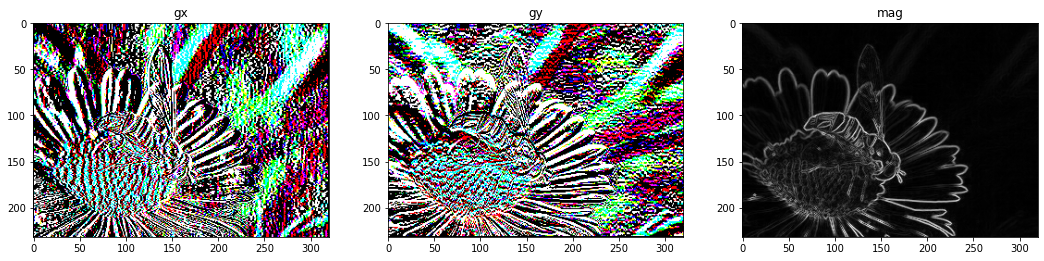

In [9]:
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 3, 1)
plt.imshow(gx)
plt.title("gx")

plt.subplot(1, 3, 2)
plt.imshow(gy)
plt.title("gy")

plt.subplot(1, 3, 3)
plt.imshow(mag, "gray")
plt.title("mag")

plt.show()